# C2_Notes_W2 - Optimization Algorithms
## Table of contents

* [1. Mini-batch gradient descent](#mini-batch-gradient-descent)
* [2. Understanding mini-batch gradient descent](#understanding-mini-batch-gradient-descent)
* [3. Exponentially weighted averages](#exponentially-weighted-averages)
* [4. Understanding exponentially weighted averages](#understanding-exponentially-weighted-averages)
* [5. Bias correction in exponentially weighted averages](#bias-correction-in-exponentially-weighted-averages)
* [6. Gradient descent with momentum](#gradient-descent-with-momentum)
* [7. RMSprop](#rmsprop)
* [8. Adam optimization algorithm](#adam-optimization-algorithm)
* [9. Learning rate decay](#learning-rate-decay)
* [10. The problem of local optima](#the-problem-of-local-optima)

# 1. Mini-batch gradient descent

- Training NN with a large data is slow. So to find an optimization algorithm that runs faster is a good idea.
- Suppose we have `m = 50 million`. To train this data it will take a huge processing time for one step.
  - because 50 million won't fit in the memory at once we need other processing to make such a thing.
- It turns out you can make a faster algorithm to make gradient descent process some of your items even before you finish the 50 million items.
- Suppose we have split m to **mini batches** of size 1000.
  - `X{1} = 0    ...  1000`
  - `X{2} = 1001 ...  2000`
  - `...`
  - `X{bs} = ...`
- We similarly split `X` & `Y`.
- So the definition of mini batches ==> `t: X{t}, Y{t}`
- In **Batch gradient descent** we run the gradient descent on the whole dataset.
- While in **Mini-Batch gradient descent** we run the gradient descent on the mini datasets.
- Mini-Batch algorithm pseudo code:
  ```
  for t = 1:No_of_batches                         # this is called an epoch
  	AL, caches = forward_prop(X{t}, Y{t})
  	cost = compute_cost(AL, Y{t})
  	grads = backward_prop(AL, caches)
  	update_parameters(grads)
  ```
- The code inside an epoch should be vectorized.
- Mini-batch gradient descent works much faster in the large datasets.


# 2. Understanding mini-batch gradient descent

- In mini-batch algorithm, the cost won't go down with each step as it does in batch algorithm. It could contain some ups and downs but generally it has to go down (unlike the batch gradient descent where cost function descreases on each iteration).
  ![](Images/04-_batch_vs_mini_batch_cost.png)
- Mini-batch size:
  - (`mini batch size = m`)  ==>    Batch gradient descent
  - (`mini batch size = 1`)  ==>    Stochastic gradient descent (SGD)
  - (`mini batch size = between 1 and m`) ==>    Mini-batch gradient descent
- Batch gradient descent:
  - too long per iteration (epoch)
- Stochastic gradient descent:
  - too noisy regarding cost minimization (can be reduced by using smaller learning rate)
  - won't ever converge (reach the minimum cost)
  - lose speedup from vectorization
- Mini-batch gradient descent:
  1. faster learning:
      - you have the vectorization advantage
      - make progress without waiting to process the entire training set
  2. doesn't always exactly converge (oscelates in a very small region, but you can reduce learning rate)
- Guidelines for choosing mini-batch size:
  1. If small training set (< 2000 examples) - use batch gradient descent.
  2. It has to be a power of 2 (because of the way computer memory is layed out and accessed, sometimes your code runs faster if your mini-batch size is a power of 2):
    `64, 128, 256, 512, 1024, ...`
  3. Make sure that mini-batch fits in CPU/GPU memory.
- Mini-batch size is a `hyperparameter`.

# 3. Exponentially weighted averages

- There are optimization algorithms that are better than **gradient descent**, but you should first learn about Exponentially weighted averages.
- If we have data like the temperature of day through the year it could be like this:
  ```
  t(1) = 40
  t(2) = 49
  t(3) = 45
  ...
  t(180) = 60
  ...
  ```
- This data is small in winter and big in summer. If we plot this data we will find it some noisy.
- Now lets compute the Exponentially weighted averages:
  ```
  V0 = 0
  V1 = 0.9 * V0 + 0.1 * t(1) = 4		# 0.9 and 0.1 are hyperparameters
  V2 = 0.9 * V1 + 0.1 * t(2) = 8.5
  V3 = 0.9 * V2 + 0.1 * t(3) = 12.15
  ...
  ```
- General equation
  ```
  V(t) = beta * v(t-1) + (1-beta) * theta(t)
  ```
- If we plot this it will represent averages over `~ (1 / (1 - beta))` entries:
    - `beta = 0.9` will average last 10 entries
    - `beta = 0.98` will average last 50 entries
    - `beta = 0.5` will average last 2 entries
- Best beta average for our case is between 0.9 and 0.98
- Another imagery example:   
    ![](Images/Nasdaq1_small.png)   
    _(taken from [investopedia.com](https://www.investopedia.com/))_


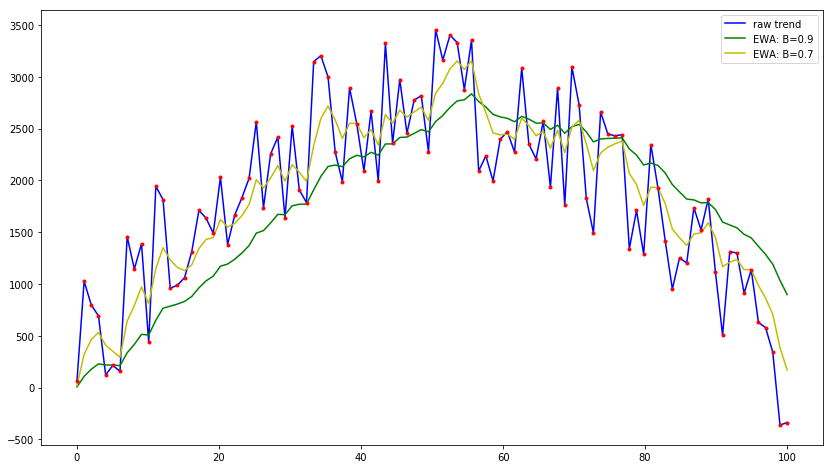

In [237]:

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
%matplotlib inline

# CREATE EXPONENTIAL WEIGHTED AVERAGE FUNCTION
def EWA(Y, beta):
    updates = []
    v=0
    for i,y in enumerate(Y):
        v = beta*v + (1-beta)*y
        updates.append(v)
    return updates

# PLOT NOISEY TREND AND EWA
np.random.seed(42)
m = 100
X = np.linspace(0,m,m)
y = (-(X-m/2)**2) + (2000) + (np.random.rand(m)*m*15)
plt.figure(figsize=(14,8))
plt.plot(X, y,"b-", label = "raw trend")
plt.plot(X, EWA(y,0.9), "g-", label = "EWA: B=0.9")
plt.plot(X, EWA(y,0.7), "y-", label = "EWA: B=0.7")
plt.plot(X, y,"r.")
plt.legend()


# 4. Understanding exponentially weighted averages

- Intuitions:   
    ![](Images/05-_exponentially_weighted_averages_intuitions.png)
    
#### As you can see, this is effectively an 'Exponentially Decaying Function' ! As you go back further in the observations, the exponent increases, making the weights of past days get smaller and smaller as we go back in time. This is why when we have a HIGHER BETA, the we effectively incorporate more days into the average (because 0.9^2 is larger than 0.5^2)... essentially higher Beta values slow down the decay!
- Another way to look at this is that it **is effectively a weighted sum of all previous days**...
- It also turns out that 0.9^10 is 0.35, which is approximately equal to 1/e... which means after 10 days, the decay will go down sharply... which is why we say a beta of 0.9 means you are effectively averaging over 10 days.
- We can implement this algorithm with more accurate results using a moving window. But the code is more efficient and faster using the exponentially weighted averages algorithm.
- Algorithm is very simple:
  ```
  v = 0
  Repeat
  {
  	Get theta(t)
  	v = beta * v + (1-beta) * theta(t)
  }
  ```

Text(0.5,1,'Decay with beta of 0.9, 0.7, 0.5')

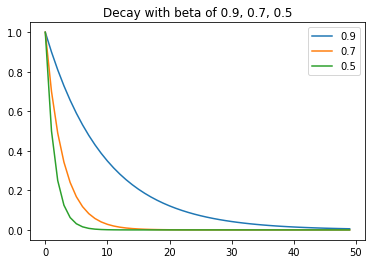

In [268]:
x1=[]
x2=[]
x3=[]

for i in range(0,50):
    x1.append(0.9**i)
    x2.append(0.7**i)
    x3.append(0.5**i)
plt.plot(x1, label="0.9")
plt.plot(x2, label="0.7")
plt.plot(x3, label="0.5")
plt.legend()
plt.title("Decay with beta of 0.9, 0.7, 0.5")


# 5. Bias correction in exponentially weighted averages

- The bias correction helps make the exponentially weighted averages more accurate.
- Because `v(0) = 0`, the bias of the weighted averages is shifted and the accuracy suffers at the start.
- To solve the bias issue we have to use this equation:
  ```
  v(t) = (beta * v(t-1) + (1-beta) * theta(t)) / (1 - beta^t)
  ```
- As t becomes larger the `(1 - beta^t)` becomes close to `1` and makes no difference really... **So this is really to help fix the bias in the initial periods**
- When beta = 0.9, the bias correction doesnt do much after days or so...

**NOTE THAT t MUST ALWAYS BE > 0... beacuse x^0 = 1, and you can't divide by zero idiot!!!!**

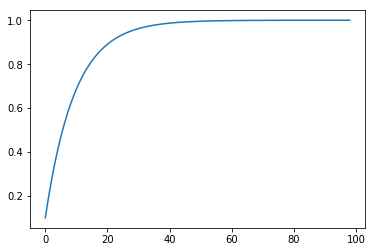

In [297]:
# PLOT BIAS TERMS
x=[]
for i in range(1,100):
    x.append(1-(0.9**i))
plt.plot(x)

In [333]:
diffs = pd.DataFrame({'NoBias':EWA(y,0.9, bias=False),'Bias':EWA(y,0.9, bias=True)})
diffs['diff'] = diffs['NoBias']-diffs['Bias']
diffs

,Bias,NoBias,diff
0,61.810178,6.181018,-55.629160
1,595.661401,108.169042,-487.492359
2,829.796330,176.945127,-652.851203
3,947.990089,228.434144,-719.555945
4,882.920146,217.765080,-665.155067
5,840.200767,217.342040,-622.858727
6,786.169985,211.253344,-574.916641
7,963.260832,335.762012,-627.498819
8,1053.760107,416.631198,-637.128909
9,1161.574513,513.823593,-647.750920


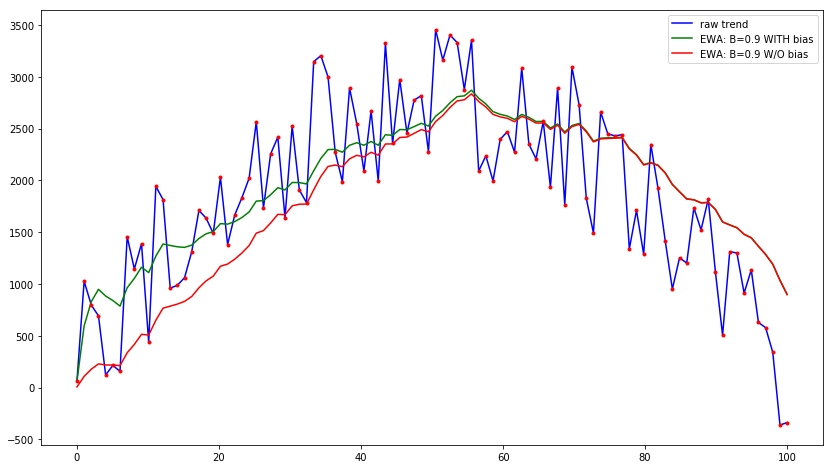

In [330]:
# UPDATE EXPONENTIAL WEIGHTED AVERAGE FUNCTION
def EWA(Y, beta, bias=True):
    updates = []
    v=0
    for i,y in enumerate(Y):
        if bias:
            v = beta*v + ((1-beta)*y) / (1-(beta**(i+1)))
        else:
            v = beta*v + (1-beta)*y
        updates.append(v)
    return updates

# PLOT NOISEY TREND AND EWA
np.random.seed(42)
m = 100
X = np.linspace(0,m,m)
y = (-(X-m/2)**2) + (2000) + (np.random.rand(m)*m*15)
plt.figure(figsize=(14,8))
plt.plot(X, y,"b-", label = "raw trend")
plt.plot(X, EWA(y,0.9, bias=True), "g-", label = "EWA: B=0.9 WITH bias")
plt.plot(X, EWA(y,0.9, bias=False), "r-", label = "EWA: B=0.9 W/O bias")

#plt.plot(X, EWA(y,0.7), "y-", label = "EWA: B=0.7")
plt.plot(X, y,"r.")
plt.legend()


# 6. Gradient descent with momentum

- The momentum algorithm almost always works faster than standard gradient descent.
- The simple idea is to calculate the exponentially weighted averages for your gradients and then update your weights with the new values.
- Pseudo code:
  ```
  vdW = 0
  vdb = 0
  on iteration t:
  	# can be mini-batch or batch gradient descent
  	compute dw, db on current mini-batch                
  			
  	vdW = beta * vdW + (1 - beta) * dW
  	vdb = beta * vdb + (1 - beta) * db
  	W = W - learning_rate * vdW
  	b = b - learning_rate * vdb
  ```
- Momentum helps the cost function to go to the minimum point in a more fast and consistent way.
- **`beta` is another `hyperparameter`**
- **`beta = 0.9` is very common and works very well in most cases.**
- In practice people don't bother implementing **bias correction**.


# 7. RMSprop

- Stands for **Root mean square prop**.
- This algorithm speeds up the gradient descent.
- Pseudo code:
  ```
  # t-1 weights
  sdW = 0
  sdb = 0
  on iteration t:
  	# can be mini-batch or batch gradient descent
  	compute dw, db on current mini-batch
  	
  	sdW = (beta * sdW) + (1 - beta) * dW^2  # squaring is element-wise
  	sdb = (beta * sdb) + (1 - beta) * db^2  # squaring is element-wise
  	W = W - learning_rate * dW / sqrt(sdW)
  	b = B - learning_rate * db / sqrt(sdb)
  ```
- RMSprop will make the cost function move slower on the vertical direction and faster on the horizontal direction in the following example:
    ![](Images/06-_RMSprop.png)
- Ensure that `sdW` is not zero by adding a small value `epsilon` (e.g. `epsilon = 10^-8`) to it:   
   `W = W - learning_rate * dW / (sqrt(sdW) + epsilon)`
- With RMSprop you can increase your learning rate.
- Developed by Geoffrey Hinton and firstly introduced on [Coursera.org](https://www.coursera.org/) course.


# 8. Adam optimization algorithm

- Stands for **Adaptive Moment Estimation**.
- Adam optimization and RMSprop are among the optimization algorithms that worked very well with a lot of NN architectures.
- **Adam optimization simply puts RMSprop and momentum together!**
- Pseudo code:
  ```
  vdW = 0, vdb = 0
  sdW = 0, sdb = 0
  on iteration t:
  	# can be mini-batch or batch gradient descent
  	compute dw, db on current mini-batch                
  			
  	vdW = (beta1 * vdW) + (1 - beta1) * dW     # momentum
  	vdb = (beta1 * vdb) + (1 - beta1) * db     # momentum
  			
  	sdW = (beta2 * sdW) + (1 - beta2) * dW^2   # RMSprop
  	sdb = (beta2 * sdb) + (1 - beta2) * db^2   # RMSprop
  			
  	vdW = vdW / (1 - beta1^t)      # fixing bias
  	vdb = vdb / (1 - beta1^t)      # fixing bias
  			
  	sdW = sdW / (1 - beta2^t)      # fixing bias
  	sdb = sdb / (1 - beta2^t)      # fixing bias
  					
  	W = W - learning_rate * vdW / (sqrt(sdW) + epsilon)
  	b = B - learning_rate * vdb / (sqrt(sdb) + epsilon)
  ```
- Hyperparameters for Adam:
  - Learning rate: needed to be tuned.
  - `beta1`: parameter of the momentum - `0.9` is recommended by default.
  - `beta2`: parameter of the RMSprop - `0.999` is recommended by default.
  - `epsilon`: `10^-8` is recommended by default.

# 9. Learning rate decay

- Slowly reduce learning rate.
- As mentioned before mini-batch gradient descent won't reach the optimum point (converge). But by making the learning rate decay with iterations it will be much closer to it because the steps (and possible oscillations) near the optimum are smaller.
- One technique equations is `learning_rate = (1 / (1 + decay_rate * epoch_num)) * learning_rate_0`  
  - `epoch_num` is over all data (not a single mini-batch).
- Other learning rate decay methods (continuous):
  - `learning_rate = (0.95 ^ epoch_num) * learning_rate_0`
  - `learning_rate = (k / sqrt(epoch_num)) * learning_rate_0`
- Some people perform learning rate decay discretely - repeatedly decrease after some number of epochs.
- Some people are making changes to the learning rate manually.
- `decay_rate` is another `hyperparameter`.
- For Andrew Ng, learning rate decay has less priority.

# 10. The problem of local optima

- The normal local optima is not likely to appear in a deep neural network because data is usually high dimensional. For point to be a local optima it has to be a local optima for each of the dimensions which is highly unlikely.
- It's unlikely to get stuck in a bad local optima in high dimensions, it is much more likely to get to the saddle point rather to the local optima, which is not a problem.
- Plateaus can make learning slow:
  - Plateau is a region where the derivative is close to zero for a long time.
  - This is where algorithms like momentum, RMSprop or Adam can help.
